## In this file, we try to predict spread
We are using BERT model to predict the spread of the assets with the following steps:
- Using spreads.csv -- has columns: 'Date', 'Ticker Pair', 'Spread', and 'Return'
- Making a texts column takin  

Desired output format: 'Date', 'Ticker Pair', 'Spread', 'Return'


In [1]:
#%pip install transformers torch

In [ ]:
import pandas as pd

# load financial data -- Note we have the following columns: Date, Ticker Pair, BERT Spread, BERT Position
data = pd.read_csv('outputs/spreads.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns={"Ticker Pair": "Ticker_Pair"}, inplace=True)
data[["tick1", "tick2"]] = data["Ticker_Pair"].str.split("-", expand=True)
# create text description for BERT to process
data['texts'] = [f"The spread for {row['Ticker_Pair']} on {row['Date'].strftime('%Y-%m-%d')} is {row['Spread']}" for index, row in data.iterrows()]


data.head()

,Date,Ticker_Pair,Spread,Return,tick1,tick2,texts
0,2019-02-28,AMD-NVDA,-1.319546,NaN,AMD,NVDA,The spread for AMD-NVDA on 2019-02-28 is -1.31...
1,2019-03-31,AMD-NVDA,-2.016620,-0.079436,AMD,NVDA,The spread for AMD-NVDA on 2019-03-31 is -2.01...
2,2019-04-30,AMD-NVDA,-1.311965,0.074661,AMD,NVDA,The spread for AMD-NVDA on 2019-04-30 is -1.31...
3,2019-05-31,AMD-NVDA,1.456130,0.242785,AMD,NVDA,The spread for AMD-NVDA on 2019-05-31 is 1.456...
4,2019-06-30,AMD-NVDA,0.568124,-0.104398,AMD,NVDA,The spread for AMD-NVDA on 2019-06-30 is 0.568...


In [ ]:
# import the bert tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


texts = data['texts'].values
spread = data['Spread'].values
print(f'Data Loaded: {len(data)} rows')
print(f'Spread distribution {sum(spread)}, {len(spread) - sum(spread)}')


## Change this for the actual task -- we will just train and predict on unseen data
# create the train/test split for regression task
train_texts, test_texts, train_spreads, test_spreads = train_test_split(
    texts, spread, test_size=0.2, random_state=42)
print(f'Train Size: {len(train_texts)}, Test Size: {len(test_texts)}')


# tokenize and encode the data using a pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize training data
train_encodings = tokenizer(
    list(train_texts), padding=True, truncation=True, return_tensors='pt', max_length=128
)
## This will not be necessary
# tokenize test data
test_encodings = tokenizer(
    list(test_texts), padding=True, truncation=True, return_tensors='pt', max_length=128
)

# Convert spread values to float tensors for regression
train_dataset = TensorDataset(train_encodings['input_ids'], 
                            train_encodings['attention_mask'], 
                            torch.tensor(train_spreads, dtype=torch.float32))
test_dataset = TensorDataset(test_encodings['input_ids'], 
                           test_encodings['attention_mask'], 
                           torch.tensor(test_spreads, dtype=torch.float32))

# create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# loading the BERT model
from transformers import BertPreTrainedModel, BertModel

class BertForRegression(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.regressor = torch.nn.Sequential(
            torch.nn.Dropout(config.hidden_dropout_prob),  # Fixed: torch.nn.Dropout instead of torch.nnDropout
            torch.nn.Linear(config.hidden_size, 1)  # Output layer for regression
        )
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, **kwargs):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,  
        )
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)

# loading the BERT model for regression (num_labels=1 for regression)
model = BertForRegression.from_pretrained('bert-base-uncased', 
                                         config=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# fine tune the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # higher learning rate for regression

# Using MSE for loss regression
loss_fn = torch.nn.MSELoss()

# epochs means one complete pass through the entire training dataset. 
# epoch 1: the model sees all training data once and makes initial adjustments
# epoch 2: the model sees the data again, learns from its previous mistakes, and makes further adjustments
# epoch 3: the model sees the data a third time, refines its understanding, and makes final adjustments
# In this case, we will use 3 epochs for training.
num_epochs = 5 # increased from 3 for regression task 

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, batch_spreads = [b.to(device) for b in batch]
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        # Reshape outputs to match target shape
        outputs = outputs.squeeze(-1)
        
        # Calculate regression loss
        loss = loss_fn(outputs, batch_spreads)
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_loader):.6f}")

# Evaluation
model.eval()
all_preds = []
all_spreads = []
eval_loss = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, batch_spreads = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        outputs = outputs.squeeze(-1)
        
        # Calculate loss
        loss = loss_fn(outputs, batch_spreads)
        eval_loss += loss.item()
        
        all_preds.extend(outputs.cpu().numpy())
        all_spreads.extend(batch_spreads.cpu().numpy())

print(f"Evaluation Loss: {eval_loss / len(test_loader):.6f}")

# Calculate regression metrics
mse = mean_squared_error(all_spreads, all_preds)
mae = mean_absolute_error(all_spreads, all_preds)
r2 = r2_score(all_spreads, all_preds)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R^2 Score: {r2:.6f}")



Data Loaded: 45 rows
Spread distribution -3.952393967665557e-14, 45.00000000000004
Train Size: 36, Test Size: 9


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['regressor.1.bias', 'regressor.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Average Loss: 1.115361
Epoch 2/5, Average Loss: 0.973783
Epoch 3/5, Average Loss: 0.671310
Epoch 4/5, Average Loss: 0.760807
Epoch 5/5, Average Loss: 0.545681
Evaluation Loss: 0.217431
Mean Squared Error: 0.217431
Mean Absolute Error: 0.283547
R^2 Score: 0.697371


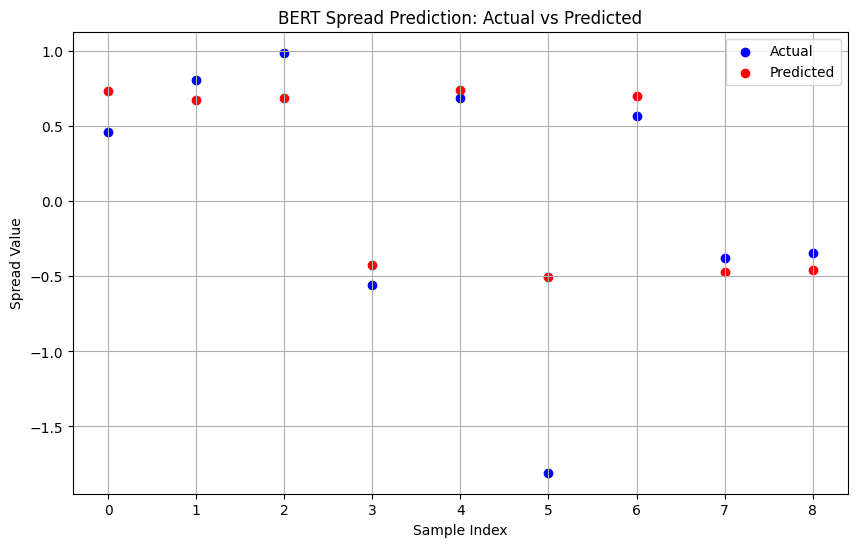

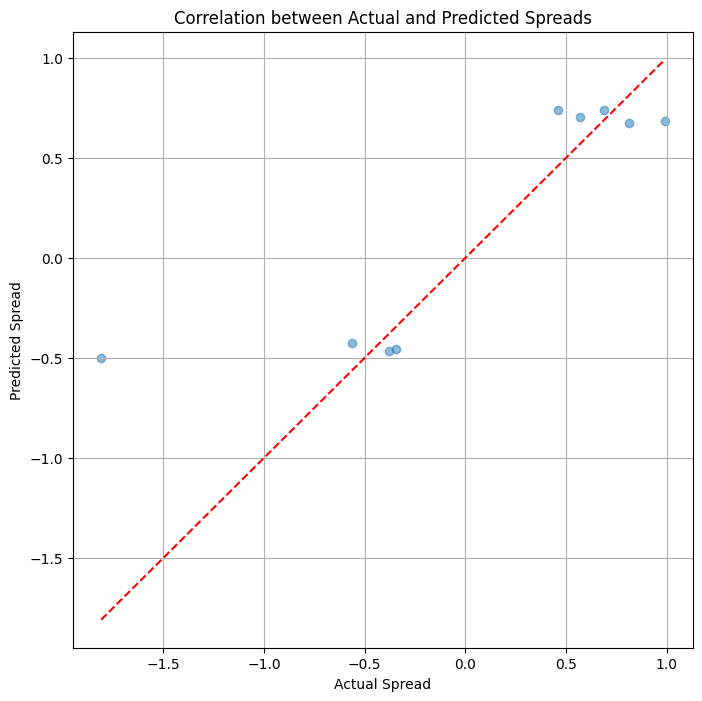

In [14]:
# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot sample of predictions (first 100 points)
sample_size = min(100, len(all_preds))
plt.scatter(range(sample_size), all_spreads[:sample_size], color='blue', label='Actual')
plt.scatter(range(sample_size), all_preds[:sample_size], color='red', label='Predicted')
plt.title('BERT Spread Prediction: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot correlation
plt.figure(figsize=(8, 8))
plt.scatter(all_spreads, all_preds, alpha=0.5)
plt.plot([min(all_spreads), max(all_spreads)], [min(all_spreads), max(all_spreads)], 'r--')
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.title('Correlation between Actual and Predicted Spreads')
plt.grid(True)
plt.show()

In [ ]:
# predict for the following dates: 1/1/2019 - 12/31/2019
# Do monthly predictions for a year after the training data